# Programming for Economists - Project 1

This paper analyzes recent inflation dynamics in Denmark using official data from Statistics Denmark and international sources such as FRED.
The objective is to understand the causes, development, and eventual stabilization of inflation following the COVID-19 pandemic.
The analysis begins with the construction of key inflation indicators — including the consumer price index (CPI), month-to-month and 12-month inflation rates — based on tables PRIS111 and PRIS113 from Statistics Denmark.
It then examines measures of instantaneous and core inflation to distinguish between short-term price fluctuations and underlying trends.

The second part compares Denmark’s inflation performance with that of other countries using harmonized international data (HICP), and summarizes key cross-country differences since 2019.
Finally, the paper extends the analysis by linking inflation to domestic labor market conditions and interest rate developments, providing a broader view of macroeconomic adjustments in the Danish economy during and after the post-pandemic inflation surge.

Imports and set magics:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
!pip install git+https://github.com/alemartinello/dstapi

# user written modules
import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/lf/zskv7rkd4g1fvv0x7l6ck5y00000gn/T/pip-req-build-7ggpef2f
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/lf/zskv7rkd4g1fvv0x7l6ck5y00000gn/T/pip-req-build-7ggpef2f
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done


# 1.1 Basics

In [18]:
# Load PRIS113 dataset manually
df = pd.read_csv("PRIS113.csv", delimiter=";", header=None)

In [19]:
# Clean data and rename columns
months = df.iloc[2, 1:]  
values = df.iloc[3, 1:]  

df_tidy = pd.DataFrame({
    "TIME": months.values,
    "VALUE": values.values.astype(float)
})

# Show result
display(df_tidy.head())

,TIME,VALUE
0,1980M02,33.3
1,1980M03,33.8
2,1980M04,34.0
3,1980M05,34.5
4,1980M06,34.6


In [20]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [21]:
# Convert TIME to datetime and VALUE to value
df_tidy['date'] = pd.to_datetime(df_tidy['TIME'], format='%YM%m', errors='coerce')
df_tidy['value'] = pd.to_numeric(df_tidy['VALUE'], errors='coerce')

# Show result
display(df_tidy.head())

,TIME,VALUE,date,value
0,1980M02,33.3,1980-02-01,33.3
1,1980M03,33.8,1980-03-01,33.8
2,1980M04,34.0,1980-04-01,34.0
3,1980M05,34.5,1980-05-01,34.5
4,1980M06,34.6,1980-06-01,34.6


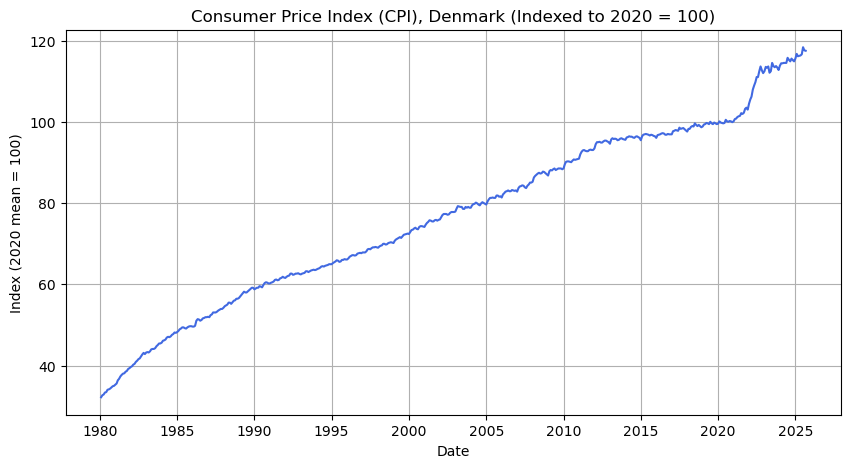

In [22]:
# Filter for 2020
df_tidy['date'] = pd.to_datetime(df_tidy['TIME'], format='%YM%m', errors='coerce')
df_tidy['value'] = pd.to_numeric(df_tidy['VALUE'], errors='coerce')
df_2020 = df_tidy[df_tidy['date'].dt.year == 2020]

# Compute mean CPI for 2020
mean_2020 = df_2020['value'].mean()

# Create a new column indexed to 2020 = 100
df_tidy['CPI_indexed'] = df_tidy['value'] / mean_2020 * 100

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_tidy['date'], df_tidy['CPI_indexed'], color='royalblue')
plt.title("Consumer Price Index (CPI), Denmark (Indexed to 2020 = 100)")
plt.xlabel("Date")
plt.ylabel("Index (2020 mean = 100)")
plt.grid(True)
plt.show()

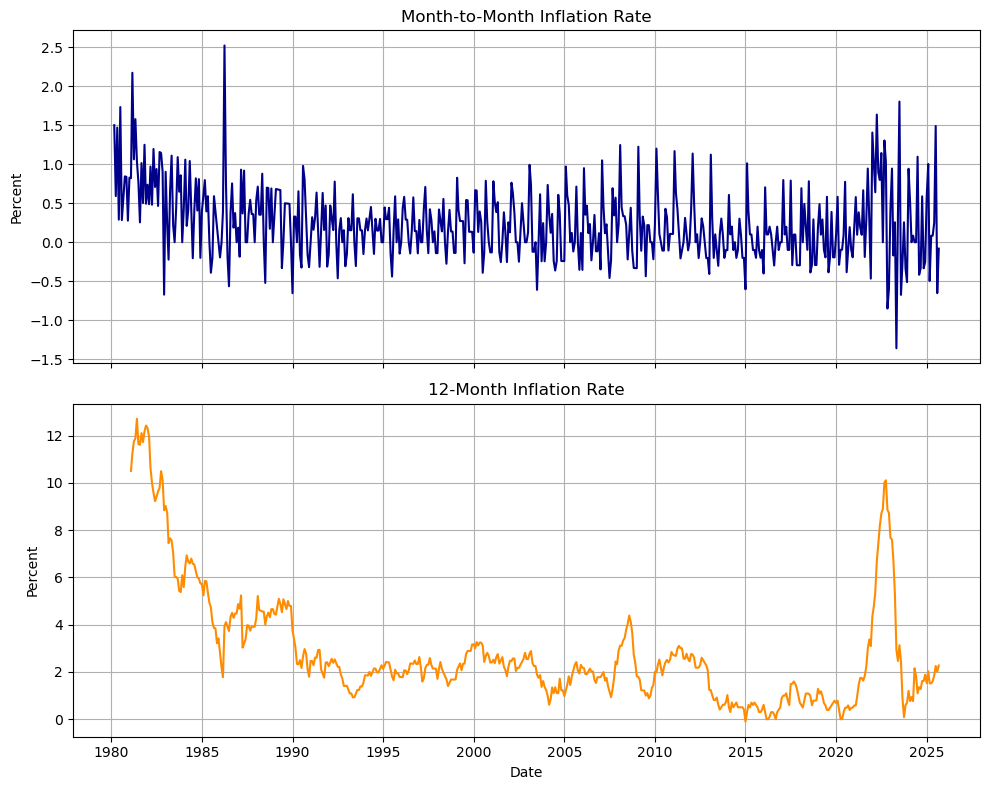

In [23]:
# Month-to-month inflation
df_tidy['pi_monthly'] = df_tidy['value'].pct_change()

# 12-month inflation
df_tidy['pi_12month'] = df_tidy['value'].pct_change(12)

# Plot both
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax[0].plot(df_tidy['date'], df_tidy['pi_monthly'] * 100, color='darkblue')
ax[0].set_title("Month-to-Month Inflation Rate")
ax[0].set_ylabel("Percent")
ax[0].grid(True)

ax[1].plot(df_tidy['date'], df_tidy['pi_12month'] * 100, color='darkorange')
ax[1].set_title("12-Month Inflation Rate")
ax[1].set_ylabel("Percent")
ax[1].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

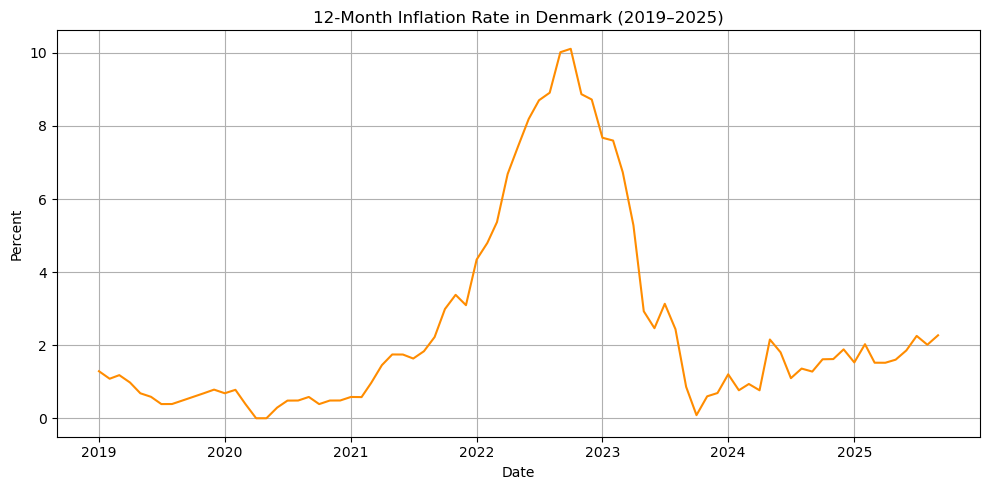

In [24]:
# Plot 12-month inflation rate for 2019–2025
mask = (df_tidy['date'] >= '2019-01-01') & (df_tidy['date'] <= '2025-12-31')
plt.figure(figsize=(10,5))
plt.plot(df_tidy.loc[mask, 'date'], df_tidy.loc[mask, 'pi_12month'] * 100, color='darkorange')
plt.title("12-Month Inflation Rate in Denmark (2019–2025)")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Find peak of 12-month inflation for 2019–2025
mask = (df_tidy['date'] >= '2019-01-01') & (df_tidy['date'] <= '2025-12-31')
df_period = df_tidy.loc[mask]

peak_idx = df_period['pi_12month'].idxmax()
peak_date = df_tidy.loc[peak_idx, 'date']
peak_value = df_tidy.loc[peak_idx, 'pi_12month']

# Find first date after the peak when inflation fell below 2%
threshold = 0.02  # 2%
after_peak = df_tidy[(df_tidy['date'] > peak_date) & (df_tidy['date'] <= '2025-12-31')]
below_threshold = after_peak[after_peak['pi_12month'] < threshold]
end_idx = below_threshold.index.min()
end_date = df_tidy.loc[end_idx, 'date'] if pd.notna(end_idx) else None

print(f"Peak inflation (2019–2025): {peak_value*100:.2f}% in {peak_date.strftime('%B %Y')}")
if end_date is not None:
    print(f"Inflation fell below 2% again in {end_date.strftime('%B %Y')}")
else:
    print("Inflation has not yet fallen below 2% after the peak (within 2025)")

Peak inflation (2019–2025): 10.11% in October 2022
Inflation fell below 2% again in September 2023


**Interpretation:** 

The Post pandemix inflation surge in Denmark ended around september 2023, when the 12-month inflation rate fell back to roughly 2% after peaking around 10% in late 2022.

# 1.2 Instantaneous inflation

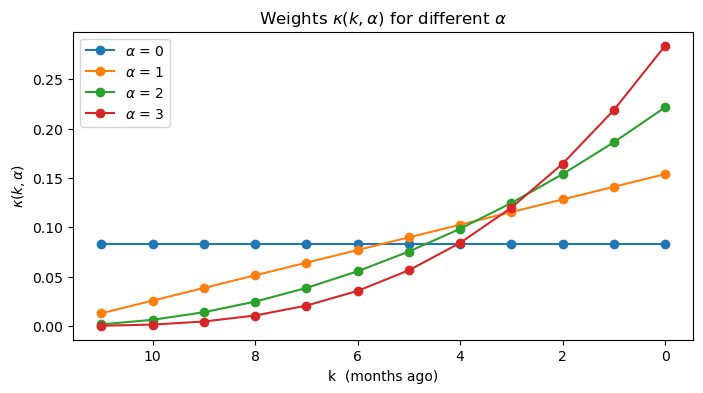

In [26]:
# Define kappa(k, $\alpha$)
def kappa_weights(alpha):
    k = np.arange(0, 12)
    T_minus_k = 12 - k
    numer = T_minus_k ** alpha
    denom = numer.sum()
    return numer / denom

# Plot $\kappa(k, \alpha)$ for $\alpha$ = 0,1,2,3
alphas = [0, 1, 2, 3]

plt.figure(figsize=(8,4))
for a in alphas:
    weights = kappa_weights(a)
    plt.plot(range(12), weights, marker='o', label=f'$\\alpha$ = {a}')
plt.gca().invert_xaxis()  # so k=0 (most recent) appears rightmost
plt.xlabel('k  (months ago)')
plt.ylabel('$\kappa(k, \\alpha)$')
plt.title('Weights $\kappa(k, \\alpha)$ for different $\\alpha$')
plt.legend()
plt.show()

In [28]:
# Make sure we have monthly inflation
pi = df_tidy['pi_monthly']

def instantaneous_inflation(pi_series, alpha):
    """
    Compute π₁₂,αₜ from monthly inflation series using 12-month rolling window.
    """
    gross = (1 + pi_series).fillna(1)  # convert to gross growth factors
    k = np.arange(0,12)
    T_minus_k = 12 - k
    weights = (T_minus_k ** alpha) / (T_minus_k ** alpha).sum()
    
    def weighted_geom_mean(x):
        # x is oldest→newest over 12 months
        if np.any(np.isnan(x)): 
            return np.nan
        return np.prod(x ** weights[::-1]) - 1   # reverse so newest gets highest α-weight
    
    return gross.rolling(window=12, min_periods=12).apply(weighted_geom_mean, raw=True)

# Compute for α = 0, 1, 2, 3 and store in df_tidy
for a in alphas:
    df_tidy[f'pi12_alpha_{a}'] = instantaneous_inflation(pi, a)

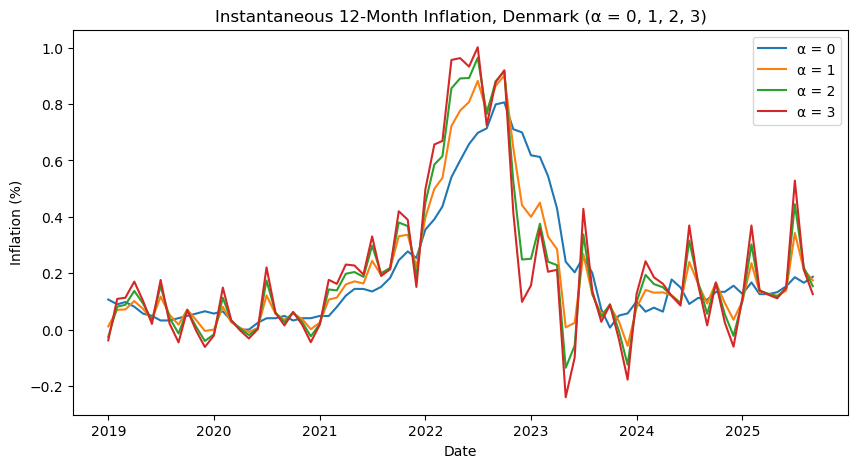

In [29]:
plt.figure(figsize=(10,5))
for a in alphas:
    plt.plot(df_tidy.loc[df_tidy['date'] >= '2019', 'date'],
             df_tidy.loc[df_tidy['date'] >= '2019', f'pi12_alpha_{a}'] * 100,
             label=f'α = {a}')
plt.title('Instantaneous 12-Month Inflation, Denmark (α = 0, 1, 2, 3)')
plt.ylabel('Inflation (%)')
plt.xlabel('Date')
plt.legend()
plt.show()

**Interpretation:** 

When $\alpha$ = 0, the instantaneous inflation is identical to the ordinary 12-month rate.
For higher $\alpha$ values (1–3), the indicator reacts faster to recent price changes, because more weight is given to the latest months.
In Denmark’s case, these weighted measures begin to decline slightly earlier than the unweighted ($\alpha$ = 0) series, suggesting that inflationary pressures started easing before the official 12-month inflation rate fully normalized.
However, all measures converge by mid-2024, confirming that the post-pandemic inflation surge had ended by then.

# 1.3 Core inflation

In [31]:
df_core = pd.read_csv("PRIS111.csv", delimiter=";", header=None, encoding="cp1252", skiprows=2)

# Inspect to confirm structure
print("Raw PRIS111 data sample:")
display(df_core.head())

Raw PRIS111 data sample:


,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,,,2019M01,2019M02,2019M03,2019M04,2019M05,2019M06,2019M07,2019M08,...,2024M12,2025M01,2025M02,2025M03,2025M04,2025M05,2025M06,2025M07,2025M08,2025M09
1,Indeks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,00 Forbrugerprisindekset i alt,102.3,102.8,102.9,103.2,103.1,102.9,103.5,103.1,...,118.9,119.6,120.8,120.2,120.3,120.4,120.7,122.5,121.7,121.6
3,,14.1 Forbrugerprisindeks ekskl. energi og ikke...,102.5,102.9,103.1,103.3,103.2,103.0,103.7,103.4,...,117.2,117.6,118.8,118.6,119.1,119.1,119.4,121.1,120.4,120.3
4,,15.1 Forbrugerprisindeks ekskl. energi,102.5,103.0,103.1,103.2,103.2,103.1,103.9,103.6,...,117.7,118.2,119.4,119.2,119.7,119.8,120.2,121.9,121.2,121.1


In [32]:
df_raw = pd.read_csv("PRIS111.csv", sep=";", header=None, encoding="cp1252", on_bad_lines="skip")

# Drop completely empty rows
df_raw = df_raw.dropna(how="all")


In [33]:
# Keep only rows 1, 3, 4, and 5
df_selected_rows = df_raw.iloc[[1, 3, 4, 5],:]

# Preview the result
display(df_selected_rows.head())

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
2,,,2019M01,2019M02,2019M03,2019M04,2019M05,2019M06,2019M07,2019M08,...,2024M12,2025M01,2025M02,2025M03,2025M04,2025M05,2025M06,2025M07,2025M08,2025M09
4,,00 Forbrugerprisindekset i alt,102.3,102.8,102.9,103.2,103.1,102.9,103.5,103.1,...,118.9,119.6,120.8,120.2,120.3,120.4,120.7,122.5,121.7,121.6
5,,14.1 Forbrugerprisindeks ekskl. energi og ikke...,102.5,102.9,103.1,103.3,103.2,103.0,103.7,103.4,...,117.2,117.6,118.8,118.6,119.1,119.1,119.4,121.1,120.4,120.3
6,,15.1 Forbrugerprisindeks ekskl. energi,102.5,103.0,103.1,103.2,103.2,103.1,103.9,103.6,...,117.7,118.2,119.4,119.2,119.7,119.8,120.2,121.9,121.2,121.1


In [107]:
# --- Extract CPI series from correct rows and compute 12-month inflation ---

# Helper to convert a row to a float array
def _row_to_arr(row):
    return pd.to_numeric(row.values, errors="coerce")

# 1. Extract months and CPI series from rows 1, 3, 4, 5
months_dt_all = pd.to_datetime(df_raw.iloc[1, 2:], format='%YM%m', errors='coerce')
cpi_total = _row_to_arr(df_raw.iloc[3, 2:])
cpi_core = _row_to_arr(df_raw.iloc[4, 2:])
cpi_excl_energy = _row_to_arr(df_raw.iloc[5, 2:])

# 2. Align all arrays to the same length (in case of trailing NaNs)
minlen = min(len(months_dt_all), len(cpi_total), len(cpi_core), len(cpi_excl_energy))
months_dt_all = months_dt_all[:minlen]
cpi_total = cpi_total[:minlen]
cpi_core = cpi_core[:minlen]
cpi_excl_energy = cpi_excl_energy[:minlen]

# 3. Compute 12-month inflation (ensure we have at least 13 months)
if len(cpi_total) <= 12:
    raise ValueError("Not enough months to compute 12-month inflation (need >12).")

infl_total = (cpi_total[12:] / cpi_total[:-12] - 1) * 100
infl_core = (cpi_core[12:] / cpi_core[:-12] - 1) * 100
infl_excl_energy = (cpi_excl_energy[12:] / cpi_excl_energy[:-12] - 1) * 100

months_12 = months_dt_all[12:].to_list()

# 4. Build a result table and display it
df_inflation = pd.DataFrame({
    "Month": months_12,
    "Total CPI (%)": infl_total,
    "Excl. Energy (%)": infl_excl_energy,
    "Core (Excl. Energy & Food) (%)": infl_core
})
df_inflation = df_inflation.round(2)

print("\nResult table (first 10 rows):")
display(df_inflation.head(10))


Result table (first 10 rows):


,Month,Total CPI (%),Excl. Energy (%),Core (Excl. Energy & Food) (%)
0,2020-01-01,0.68,0.68,0.59
1,2020-02-01,0.78,0.97,0.97
2,2020-03-01,0.39,0.87,0.68
3,2020-04-01,0.00,1.07,0.77
4,2020-05-01,0.00,0.87,0.68
5,2020-06-01,0.29,0.97,0.87
6,2020-07-01,0.48,0.96,0.96
7,2020-08-01,0.48,0.87,0.87
8,2020-09-01,0.58,0.97,0.97
9,2020-10-01,0.39,0.87,0.87


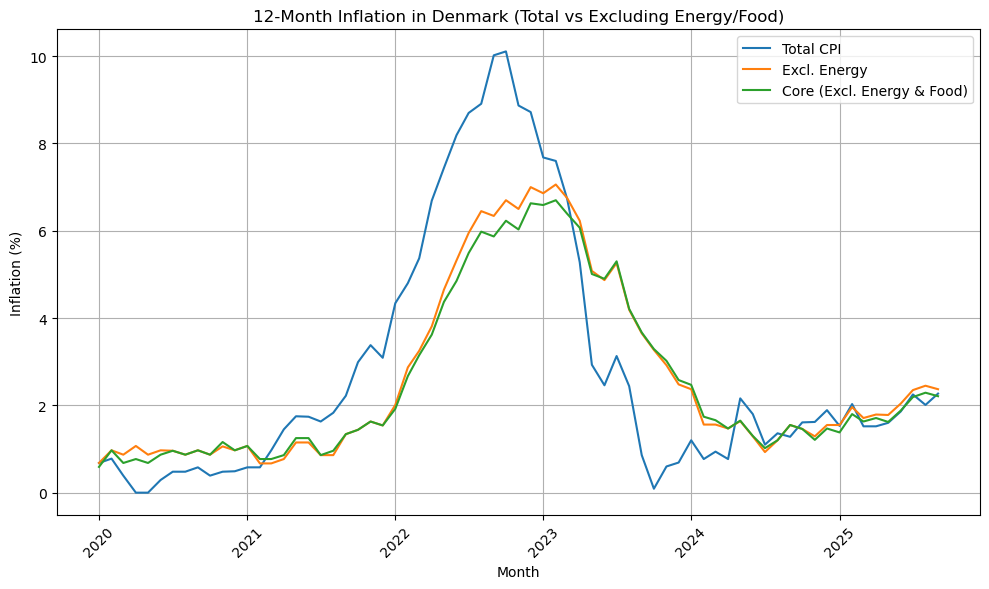

In [108]:
# --- 6. Plot ---
plt.figure(figsize=(10,6))
plt.plot(df_inflation["Month"], df_inflation["Total CPI (%)"], label="Total CPI")
plt.plot(df_inflation["Month"], df_inflation["Excl. Energy (%)"], label="Excl. Energy")
plt.plot(df_inflation["Month"], df_inflation["Core (Excl. Energy & Food) (%)"], label="Core (Excl. Energy & Food)")
plt.title("12-Month Inflation in Denmark (Total vs Excluding Energy/Food)")
plt.xlabel("Month")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation:** 

The total CPI peaked around 2022 due to spikes in energy and food prices.
Excluding energy and core measures were lower and more stable, indicating that energy and food were big drivers of the post-pandemic inflation surge.
By 2024, inflation across all measures returned near 2 %, signaling normalization.

# 1.4 Disaggregated inflation in Denmark

In [109]:
from dstapi import DstApi
levels = DstApi('PRIS111').variable_levels('VAREGR',language='en')
for row in levels.itertuples(): print(row.id,row.text)

000000 00 Consumer price index, total
010000 01 Food and non-alcoholic beverages
011000 01.1 Food
011100 01.1.1 Bread and cereals
011110 01.1.1.1 Rice
011120 01.1.1.2 Flours and other cereals
011130 01.1.1.3 Bread
011140 01.1.1.4 Other bakery products
011150 01.1.1.5 Pizza and quiche
011160 01.1.1.6 Pasta products and couscous
011170 01.1.1.7 Breakfast cereals
011180 01.1.1.8 Other cereal products
011200 01.1.2 Meat
011210 01.1.2.1 Beef and veal
011220 01.1.2.2 Pork
011230 01.1.2.3 Lamb and goat
011240 01.1.2.4 Poultry
011260 01.1.2.6 Edible offal
011270 01.1.2.7 Dried, salted or smoked meat
011280 01.1.2.8 Other meat preparations
011300 01.1.3 Fish and seafood
011310 01.1.3.1 Fresh or chilled fish
011320 01.1.3.2 Frozen fish
011340 01.1.3.4 Frozen seafood
011350 01.1.3.5 Dried, smoked or salted fish and seafood
011360 01.1.3.6 Other preserved or processed fish and seafood-based preparations
011400 01.1.4 Milk, cheese and eggs
011410 01.1.4.1 Milk, whole, fresh
011420 01.1.4.2 Milk, lo

In [110]:
# Create a table from levels
df_levels = pd.DataFrame({'CategoryID': levels['id'], 'Description': levels['text']})

# Keep only 6-digit codes where the last two digits are '00' and the first four are not '0000'
df_4digit = df_levels[df_levels['CategoryID'].str.match(r'^(?!0000)\d{4}00$')]

# Show the filtered 4-digit product categories
display(df_4digit)


,CategoryID,Description
1,010000,01 Food and non-alcoholic beverages
2,011000,01.1 Food
3,011100,01.1.1 Bread and cereals
12,011200,01.1.2 Meat
20,011300,01.1.3 Fish and seafood
...,...,...
377,127000,12.7 Other services n.e.c.
381,131000,13.1 Goods (total)
382,132000,13.2 Services (total)
383,141000,14.1 Overall Consumer Price Index - excl. ener...


In [111]:
# Load excel
df_products = pd.read_excel("VAREGR.xlsx", skiprows=2, engine="openpyxl")

# Remove completely blank rows
df_products = df_products[df_products.iloc[:, 1].notna()]

# Convert commas to dots for numeric columns ---
value_columns = [col for col in df_products.columns if str(col).startswith("20")]
df_products[value_columns] = (
    df_products[value_columns]
    .replace(",", ".", regex=True)
)

# Convert all numeric columns to float safely
for col in value_columns:
    df_products[col] = pd.to_numeric(df_products[col], errors="coerce")

# Split column B (index 1) into Code + CategoryName
df_products[["Code", "CategoryName"]] = (
    df_products.iloc[:, 1]
    .astype(str)
    .str.extract(r'^(\S+)\s+(.*)$')   # first token = code, rest = name
)

# Melt to long format
df_melted = df_products.melt(
    id_vars=["Code", "CategoryName"],
    value_vars=value_columns,
    var_name="TIME",
    value_name="CPI"
)

# Convert TIME to datetime
df_melted["TIME"] = pd.to_datetime(df_melted["TIME"], format="%YM%m", errors="coerce")

# Keep only rows with valid CPI 
df_clean = df_melted[df_melted["CPI"].notna()].copy()
df_clean.reset_index(drop=True, inplace=True)

# Final cleaned dataset
print(df_clean.head(10))


       Code                               CategoryName       TIME    CPI
0        00                Forbrugerprisindekset i alt 2010-10-01   93.8
1        01  Fødevarer og ikke-alkoholiske drikkevarer 2010-10-01   92.1
2      01.1                                  Fødevarer 2010-10-01   91.3
3    01.1.1                      Brød og kornprodukter 2010-10-01   90.8
4  01.1.1.1                                        Ris 2010-10-01  106.0
5  01.1.1.2                                Mel og gryn 2010-10-01   81.8
6  01.1.1.3                                       Brød 2010-10-01   92.9
7  01.1.1.4                              Andet bagværk 2010-10-01   87.8
8  01.1.1.5                         Pizza og madtærter 2010-10-01   99.2
9  01.1.1.6                 Pastaprodukter og couscous 2010-10-01   93.3


/var/folders/lf/zskv7rkd4g1fvv0x7l6ck5y00000gn/T/ipykernel_47101/3215012092.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_products[["Code", "CategoryName"]] = (
/var/folders/lf/zskv7rkd4g1fvv0x7l6ck5y00000gn/T/ipykernel_47101/3215012092.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_products[["Code", "CategoryName"]] = (


In [112]:
# Keep only 4-digit product categories (e.g. 01.1.1.1)
df_4digit = df_clean[df_clean['Code'].str.count(r'\.') == 3].copy()

In [113]:
# Compute 12-month inflation
df_4digit['Inflation'] = df_4digit.groupby('Code')['CPI'].pct_change(periods=12) * 100


In [114]:
# Compute percentiles across product categories
df_percentiles = (
    df_4digit.groupby('TIME')['Inflation']
    .agg(p25=lambda x: x.quantile(0.25),
         p50='median',
         p75=lambda x: x.quantile(0.75))
    .reset_index()
)

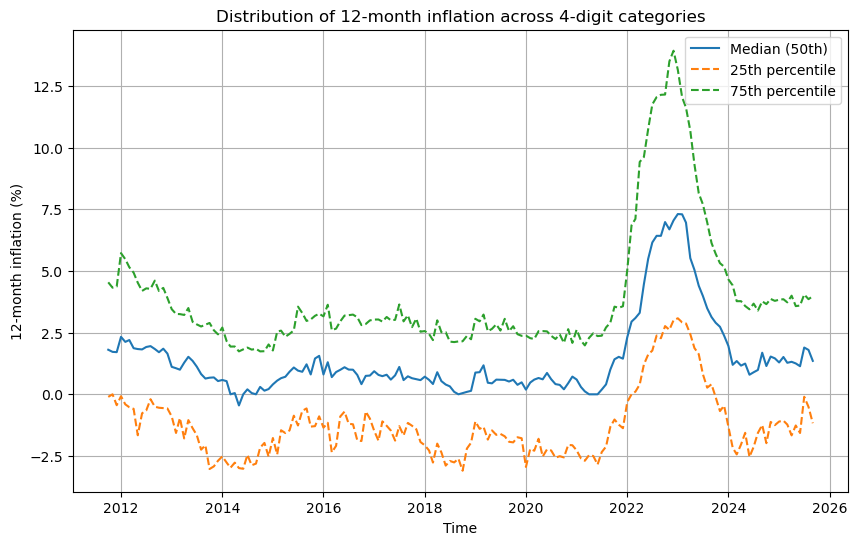

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df_percentiles['TIME'], df_percentiles['p50'], label='Median (50th)')
plt.plot(df_percentiles['TIME'], df_percentiles['p25'], '--', label='25th percentile')
plt.plot(df_percentiles['TIME'], df_percentiles['p75'], '--', label='75th percentile')
plt.xlabel('Time')
plt.ylabel('12-month inflation (%)')
plt.title('Distribution of 12-month inflation across 4-digit categories')
plt.legend()
plt.grid(True)
plt.show()


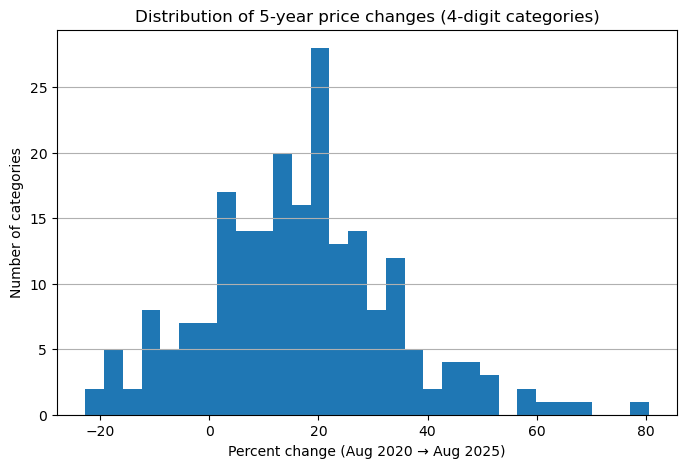

In [117]:
# Pick Aug 2020 and Aug 2025
date_start = '2020-08-01'
date_end   = '2025-08-01'

# CPI in those months per Code
df_pivot = df_4digit.pivot_table(index='Code', columns='TIME', values='CPI')

# Compute percent change between dates
df_pivot['PctChange'] = (df_pivot[pd.Timestamp(date_end)] / df_pivot[pd.Timestamp(date_start)] - 1) * 100

# Drop NaNs
df_changes = df_pivot[['PctChange']].dropna().reset_index()

# Histogram
plt.figure(figsize=(8,5))
plt.hist(df_changes['PctChange'], bins=30)
plt.xlabel('Percent change (Aug 2020 → Aug 2025)')
plt.ylabel('Number of categories')
plt.title('Distribution of 5-year price changes (4-digit categories)')
plt.grid(axis='y')
plt.show()

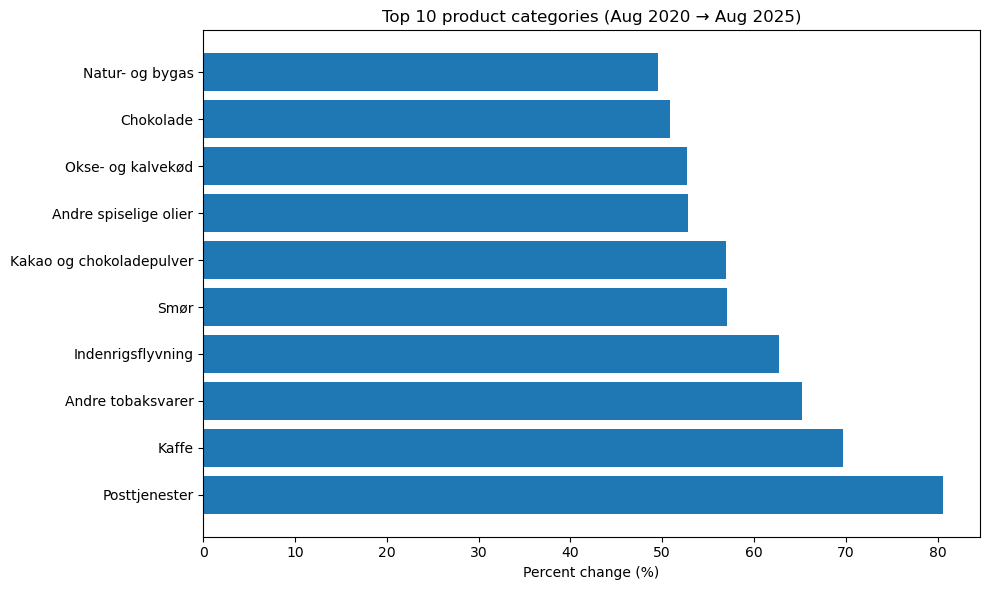

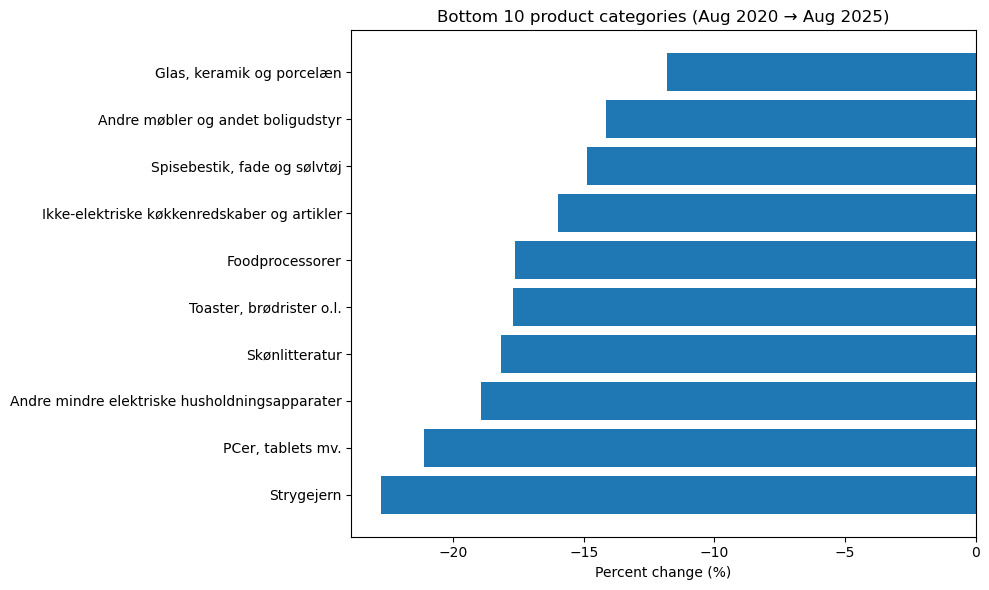

In [ ]:
# Merge category names back
df_topbottom = df_changes.merge(df_4digit[['Code','CategoryName']].drop_duplicates(), on='Code', how='left')

# Top & bottom 10
top10 = df_topbottom.nlargest(10, 'PctChange')
bottom10 = df_topbottom.nsmallest(10, 'PctChange')

# --- Plot top 10 ---
plt.figure(figsize=(10,6))
plt.barh(top10['CategoryName'], top10['PctChange'])
plt.xlabel('Percent change (%)')
plt.title('Top 10 product categories (Aug 2020 → Aug 2025)')
plt.tight_layout()
plt.show()

# --- Plot bottom 10 ---
plt.figure(figsize=(10,6))
plt.barh(bottom10['CategoryName'], bottom10['PctChange'])
plt.xlabel('Percent change (%)')
plt.title('Bottom 10 product categories (Aug 2020 → Aug 2025)')
plt.tight_layout()
plt.show()

# 2 International Comparison

# 2.1 CPI vs HICP

In [ ]:
df_fred = pd.read_csv("FRED.csv", encoding="cp1252")
df_fred = df_fred.rename(columns={
    "observation_date": "DATE",
    "CP0000DKM086NEST": "HICP"
})
print(df_fred.shape)
print(df_fred.columns)
display(df_fred.head())

(357, 2)
Index(['DATE', 'HICP'], dtype='object')


,DATE,HICP
0,1996-01-01,70.4
1,1996-02-01,70.8
2,1996-03-01,71.3
3,1996-04-01,71.5
4,1996-05-01,71.7


In [ ]:
# Prepare Danish CPI for merge with FRED
df_cpi = df_tidy[['date', 'value']].copy()
df_cpi = df_cpi.rename(columns={'date': 'DATE', 'value': 'CPI_Denmark'})
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'])  # Ensure datetime type

# Preview
display(df_cpi.head())

,DATE,CPI_Denmark
0,1980-02-01,33.3
1,1980-03-01,33.8
2,1980-04-01,34.0
3,1980-05-01,34.5
4,1980-06-01,34.6


In [ ]:
df_fred['DATE'] = pd.to_datetime(df_fred['DATE'])
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'])

# Merge on DATE
df_compare = pd.merge(df_cpi, df_fred, on='DATE', how='inner')

# Show both HICP and CPI_Denmark columns
display(df_compare[['DATE', 'CPI_Denmark', 'HICP']].head())

,DATE,CPI_Denmark,HICP
0,1996-01-01,68.4,70.4
1,1996-02-01,68.7,70.8
2,1996-03-01,69.1,71.3
3,1996-04-01,69.3,71.5
4,1996-05-01,69.5,71.7


In [ ]:
df_compare = df_compare.sort_values("DATE")
df_compare["CPI_Inflation12"] = df_compare["CPI_Denmark"].pct_change(12) * 100
df_compare["HICP_Inflation12"] = df_compare["HICP"].pct_change(12) * 100

display(df_compare.tail())

,DATE,CPI_Denmark,HICP,CPI_Inflation12,HICP_Inflation12
352,2025-05-01,120.4,120.5,1.603376,1.516428
353,2025-06-01,120.7,120.9,1.856540,1.767677
354,2025-07-01,122.5,122.9,2.253756,2.161264
355,2025-08-01,121.7,122.0,2.011735,1.921470
356,2025-09-01,121.6,121.8,2.270816,2.181208


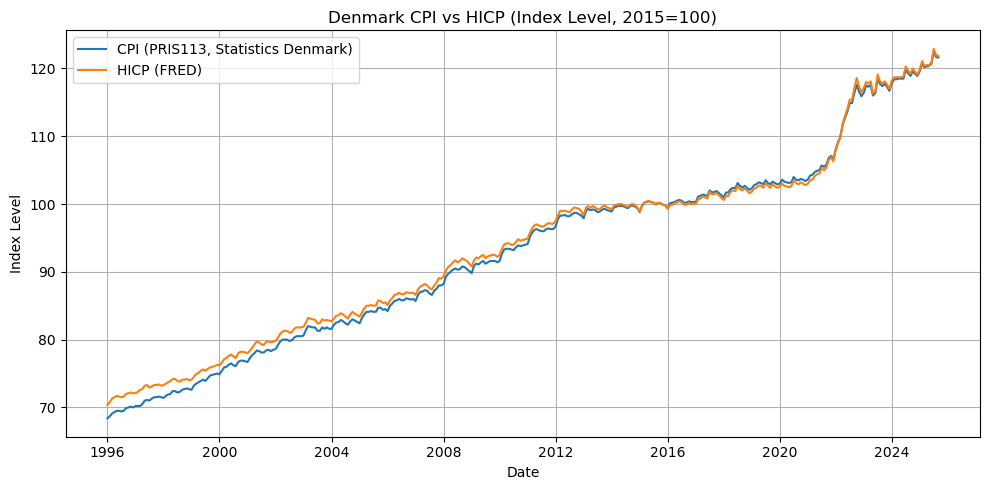

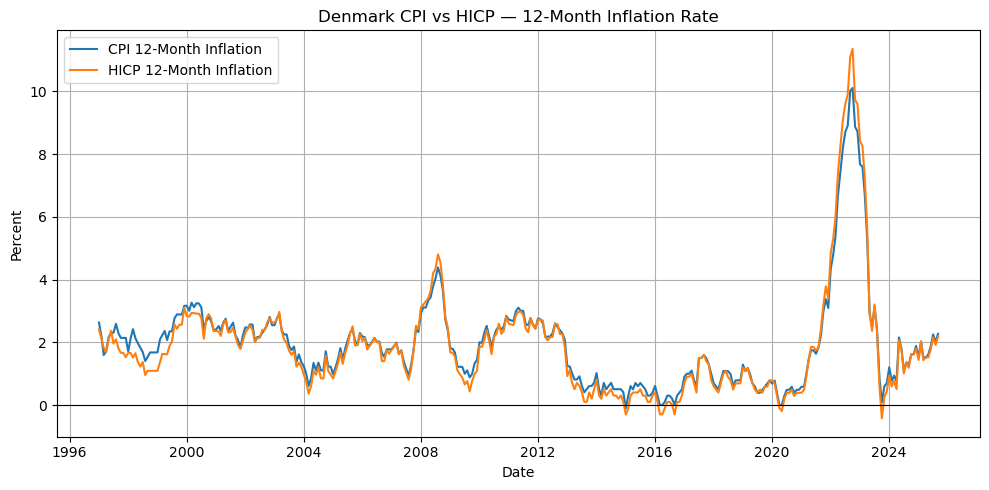

In [ ]:
# Create two plots to visualize data
# Index levels
plt.figure(figsize=(10,5))
plt.plot(df_compare["DATE"], df_compare["CPI_Denmark"], label="CPI (PRIS113, Statistics Denmark)")
plt.plot(df_compare["DATE"], df_compare["HICP"], label="HICP (FRED)")
plt.title("Denmark CPI vs HICP (Index Level, 2015=100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 12-month inflation rates
plt.figure(figsize=(10,5))
plt.plot(df_compare["DATE"], df_compare["CPI_Inflation12"], label="CPI 12-Month Inflation")
plt.plot(df_compare["DATE"], df_compare["HICP_Inflation12"], label="HICP 12-Month Inflation")
plt.title("Denmark CPI vs HICP — 12-Month Inflation Rate")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:** 
 
The Danish CPI and HICP show similar inflation trends but are not fully comparable. The HICP is harmonized for international comparison and may differ from the national CPI in coverage and weighting. For cross-country analysis, HICP is preferred; for domestic policy or contracts, the national CPI is preffered.

# 2.2 Across countries

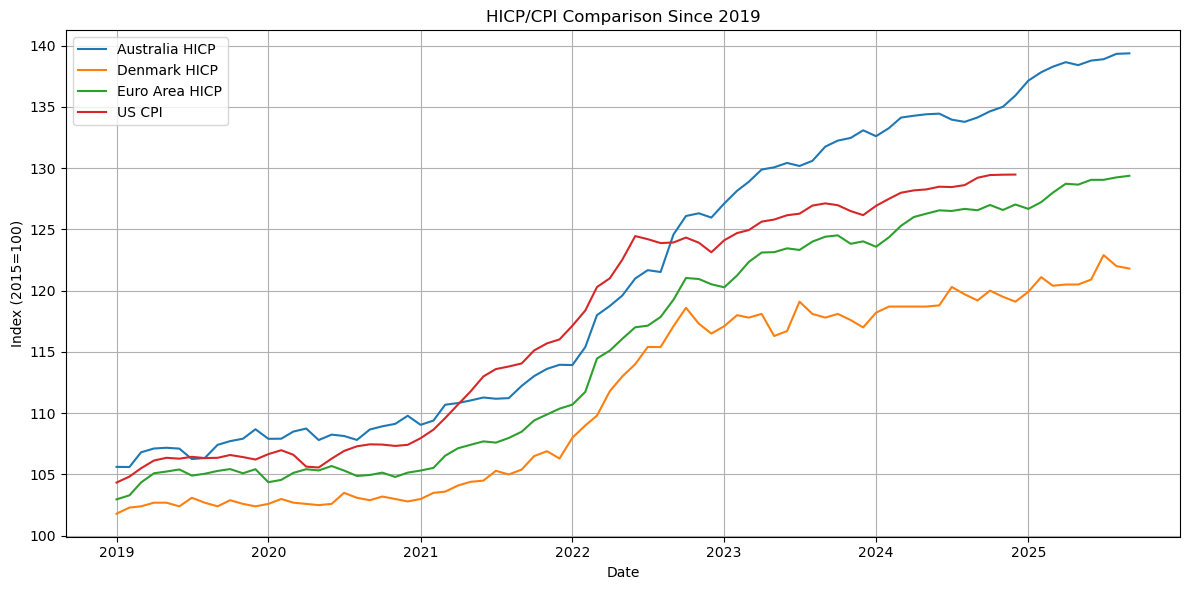

In [ ]:
# Load data
df_aus = pd.read_csv("AUS.csv")
df_den = pd.read_csv("DEN.csv")
df_euro = pd.read_csv("EURO.csv")
df_us = pd.read_csv("US.csv")

# Standardize column names
df_aus = df_aus.rename(columns={"observation_date": "DATE", "CP0000ATM086NEST": "AUS_HICP"})
df_den = df_den.rename(columns={"observation_date": "DATE", "CP0000DKM086NEST": "DEN_HICP"})
df_euro = df_euro.rename(columns={"observation_date": "DATE", "CP0000EZ19M086NEST": "EURO_HICP"})
df_us = df_us.rename(columns={"observation_date": "DATE", "CP0000USM086NEST": "US_CPI"})

# Merge on DATE
df_all = df_aus.merge(df_den, on="DATE", how="outer") \
               .merge(df_euro, on="DATE", how="outer") \
               .merge(df_us, on="DATE", how="outer")

# Convert DATE to datetime and filter since 2019
df_all["DATE"] = pd.to_datetime(df_all["DATE"])
df_all = df_all[df_all["DATE"] >= "2019-01-01"]
df_all = df_all.sort_values("DATE")

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_all["DATE"], df_all["AUS_HICP"], label="Australia HICP")
plt.plot(df_all["DATE"], df_all["DEN_HICP"], label="Denmark HICP")
plt.plot(df_all["DATE"], df_all["EURO_HICP"], label="Euro Area HICP")
plt.plot(df_all["DATE"], df_all["US_CPI"], label="US CPI")
plt.xlabel("Date")
plt.ylabel("Index (2015=100)")
plt.title("HICP/CPI Comparison Since 2019")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/lf/zskv7rkd4g1fvv0x7l6ck5y00000gn/T/ipykernel_33481/3309740863.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_all["US_Inflation12"] = df_all["US_CPI"].pct_change(12) * 100


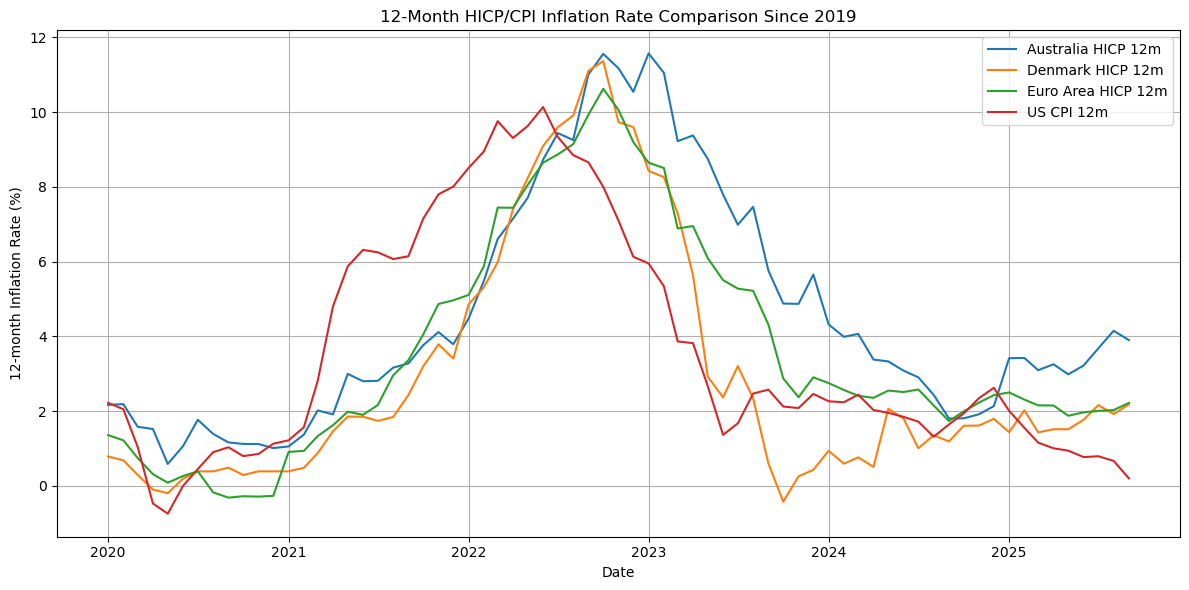

In [ ]:
# Compute 12-month inflation rates for each country
df_all["AUS_Inflation12"] = df_all["AUS_HICP"].pct_change(12) * 100
df_all["DEN_Inflation12"] = df_all["DEN_HICP"].pct_change(12) * 100
df_all["EURO_Inflation12"] = df_all["EURO_HICP"].pct_change(12) * 100
df_all["US_Inflation12"] = df_all["US_CPI"].pct_change(12) * 100

# Plot 12-month inflation rates
plt.figure(figsize=(12,6))
plt.plot(df_all["DATE"], df_all["AUS_Inflation12"], label="Australia HICP 12m")
plt.plot(df_all["DATE"], df_all["DEN_Inflation12"], label="Denmark HICP 12m")
plt.plot(df_all["DATE"], df_all["EURO_Inflation12"], label="Euro Area HICP 12m")
plt.plot(df_all["DATE"], df_all["US_Inflation12"], label="US CPI 12m")
plt.xlabel("Date")
plt.ylabel("12-month Inflation Rate (%)")
plt.title("12-Month HICP/CPI Inflation Rate Comparison Since 2019")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Print min, max, mean 12-month inflation rate by year and country in a table

# Add a 'Year' column if not already present
df_all['Year'] = df_all['DATE'].dt.year

# Prepare for aggregation
infl_cols = ['AUS_Inflation12', 'DEN_Inflation12', 'EURO_Inflation12', 'US_Inflation12']

# Melt to long format for easier groupby
df_long = df_all.melt(id_vars=['DATE', 'Year'], value_vars=infl_cols,
                      var_name='Country', value_name='Inflation12')

# Clean country names
df_long['Country'] = df_long['Country'].str.replace('_Inflation12', '').str.replace('US', 'USA')

# Drop missing values
df_long = df_long.dropna(subset=['Inflation12'])

# Group by year and country, then aggregate
summary = df_long.groupby(['Year', 'Country'])['Inflation12'].agg(['min', 'max', 'mean']).round(2)

# Reset index for a nice table
summary = summary.reset_index()

# Display min, max, mean 12-month inflation rate by country for each year as separate tables

years = summary['Year'].unique()
for year in years:
    display(
        summary[summary['Year'] == year][['Country', 'min', 'max', 'mean']]
        .set_index('Country')
        .style.format("{:.2f}")
        .set_caption(f"12-Month Inflation Statistics by Country — {year}")
    )

,min,max,mean
Country,,,
AUSA,0.59,2.19,1.39
DEN,-0.19,0.79,0.33
EURO,-0.31,1.36,0.26
USA,-0.74,2.22,0.77


,min,max,mean
Country,,,
AUSA,1.06,4.11,2.76
DEN,0.39,3.79,1.94
EURO,0.91,4.96,2.59
USA,1.22,8.01,5.33


,min,max,mean
Country,,,
AUSA,4.48,11.55,8.59
DEN,4.85,11.36,8.51
EURO,5.11,10.62,8.36
USA,6.13,10.13,8.69


,min,max,mean
Country,,,
AUSA,4.87,11.57,7.78
DEN,-0.42,8.43,3.44
EURO,2.37,8.64,5.46
USA,1.37,5.95,3.03


,min,max,mean
Country,,,
AUSA,1.81,4.32,2.93
DEN,0.51,2.06,1.27
EURO,1.74,2.75,2.36
USA,1.32,2.62,2.03


,min,max,mean
Country,,,
AUSA,2.98,4.15,3.46
DEN,1.43,2.18,1.77
EURO,1.88,2.50,2.14
USA,0.20,2.01,1.01


# 3. Extension

# 3.1 Inflation vs Interest Rates - The Monetary police response

In [ ]:
# Load interest rate data from FRED
df_rate = pd.read_csv("Rente.csv", encoding="cp1252")

# Quick preview of the interest rate data (to see column names)
display(df_rate.head())
print(df_rate.columns)

,observation_date,IRLTLT01DKM156N
0,1987-01-01,11.093
1,1987-02-01,11.362
2,1987-03-01,11.850
3,1987-04-01,11.532
4,1987-05-01,11.113


Index(['observation_date', 'IRLTLT01DKM156N'], dtype='object')


In [ ]:
# Rename columns and keep only 2019–2025
df_rate = df_rate.rename(columns={
    "observation_date": "DATE",
    "IRLTLT01DKM156N": "InterestRate_Denmark"
})
df_rate["DATE"] = pd.to_datetime(df_rate["DATE"])
df_rate = df_rate[(df_rate["DATE"] >= "2019-01-01") & (df_rate["DATE"] <= "2025-12-31")]

display(df_rate.head())
display(df_cpi.head())
display(df_fred.head())


,DATE,InterestRate_Denmark
384,2019-01-01,0.153
385,2019-02-01,0.054
386,2019-03-01,0.163
387,2019-04-01,0.082
388,2019-05-01,0.044


,DATE,CPI_Denmark
467,2019-01-01,102.3
468,2019-02-01,102.8
469,2019-03-01,102.9
470,2019-04-01,103.2
471,2019-05-01,103.1


,DATE,HICP
276,2019-01-01,101.8
277,2019-02-01,102.3
278,2019-03-01,102.4
279,2019-04-01,102.7
280,2019-05-01,102.7


In [ ]:
# Merge CPI, HICP, and interest rate data
df_compare = pd.merge(df_cpi, df_fred, on="DATE", how="inner")
df_compare = pd.merge(df_compare, df_rate, on="DATE", how="inner")

# Compute 12-month HICP inflation rate
df_compare = df_compare.sort_values("DATE")
df_compare["Inflation_12M"] = df_compare["HICP"].pct_change(12) * 100
df_compare = df_compare.dropna(subset=["Inflation_12M"])

# Compute real interest rate (nominal – inflation)
df_compare["RealRate"] = df_compare["InterestRate_Denmark"] - df_compare["Inflation_12M"]

display(df_compare.head())

,DATE,CPI_Denmark,HICP,InterestRate_Denmark,Inflation_12M,RealRate
12,2020-01-01,103.0,102.6,-0.259,0.785855,-1.044855
13,2020-02-01,103.6,103.0,-0.411,0.684262,-1.095262
14,2020-03-01,103.3,102.7,-0.409,0.292969,-0.701969
15,2020-04-01,103.2,102.6,-0.210,-0.097371,-0.112629
16,2020-05-01,103.1,102.5,-0.288,-0.194742,-0.093258


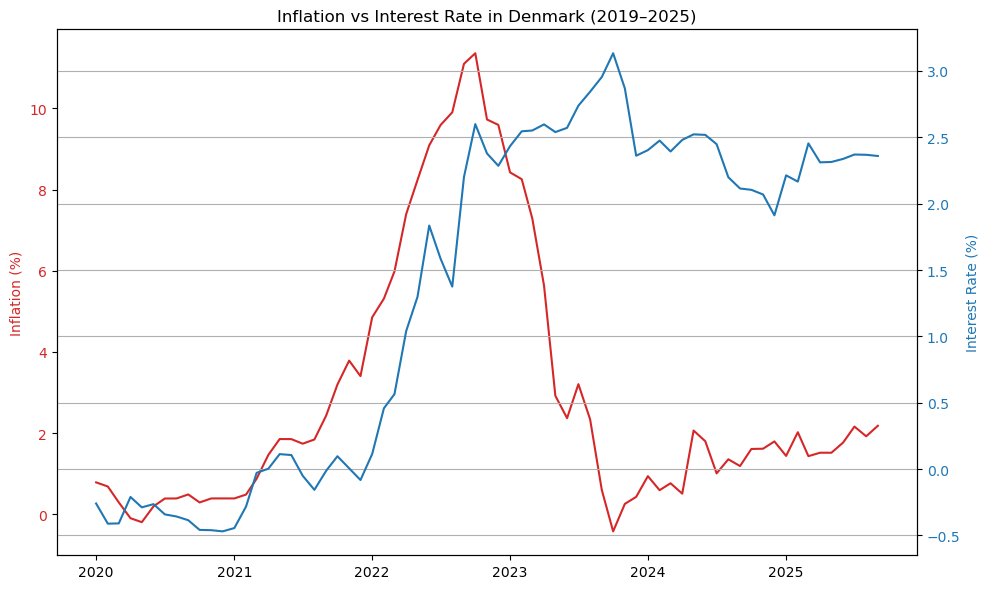

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Inflation (red)
ax1.plot(df_compare["DATE"], df_compare["Inflation_12M"], color="tab:red", label="12-Month Inflation (HICP)")
ax1.set_ylabel("Inflation (%)", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Interest rate (blue)
ax2 = ax1.twinx()
ax2.plot(df_compare["DATE"], df_compare["InterestRate_Denmark"], color="tab:blue", label="Interest Rate")
ax2.set_ylabel("Interest Rate (%)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Inflation vs Interest Rate in Denmark (2019–2025)")
plt.grid(True)
fig.tight_layout()
plt.show()



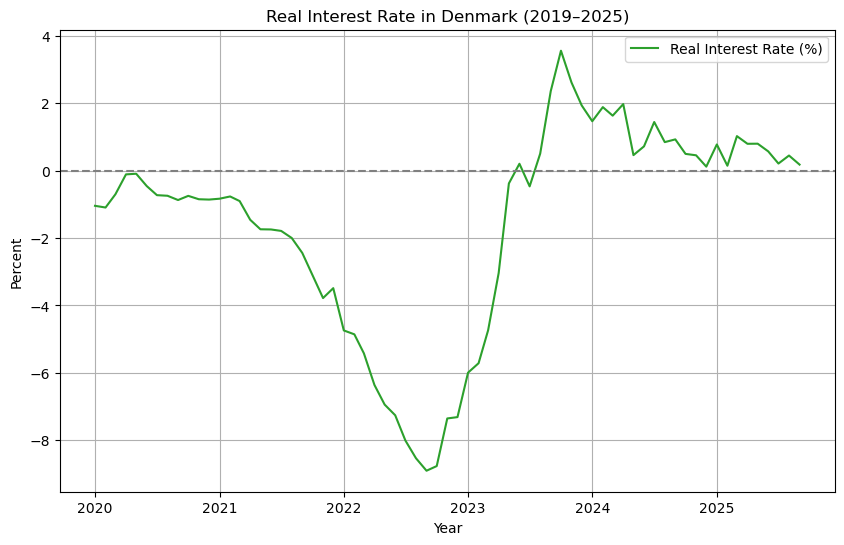

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_compare["DATE"], df_compare["RealRate"], color="tab:green", label="Real Interest Rate (%)")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Real Interest Rate in Denmark (2019–2025)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)
plt.show()


**Interpretation:** 

This analysis compares Denmark’s 12-month HICP inflation with its interest rate from 2019–2025.
Inflation surged sharply in 2021–2022, peaking above 9%, while interest rates remained near zero until early 2022.

Policy tightening began thereafter, leading to the highest rates in over a decade by 2023.
The real interest rate — adjusted for inflation — was negative during the inflation surge, meaning borrowing costs were below price growth.
By 2024, real rates turned positive as inflation cooled, signaling that monetary policy had successfully shifted to restrain price pressures.

# 3.2 Inflation vs Employment

In [ ]:
# Rename columns
df_emp = df_emp.rename(columns={
    "observation_date": "DATE",
    "LRHUTTTTDKM156S": "EmploymentRate"
})

# Convert to datetime and keep 2019–2025
df_emp["DATE"] = pd.to_datetime(df_emp["DATE"], errors="coerce")
df_emp = df_emp[(df_emp["DATE"] >= "2019-01-01") & (df_emp["DATE"] <= "2025-12-31")]

# Drop missing values
df_emp = df_emp.dropna(subset=["EmploymentRate"])

display(df_emp.head())

,DATE,EmploymentRate
432,2019-01-01,5.1
433,2019-02-01,5.1
434,2019-03-01,5.2
435,2019-04-01,5.4
436,2019-05-01,4.8


In [ ]:
# Merge employment with inflation data
df_macro = pd.merge(df_compare[["DATE", "Inflation_12M"]], df_emp, on="DATE", how="inner")

display(df_macro.head())


,DATE,Inflation_12M,EmploymentRate
0,2020-01-01,0.785855,4.7
1,2020-02-01,0.684262,5.3
2,2020-03-01,0.292969,4.8
3,2020-04-01,-0.097371,4.2
4,2020-05-01,-0.194742,5.3


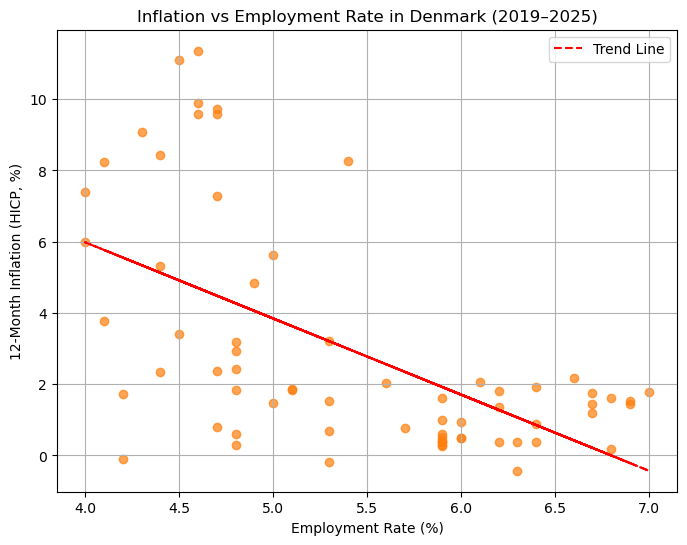

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_macro["EmploymentRate"], df_macro["Inflation_12M"], 
            color="tab:orange", alpha=0.7)

# Add labels and trend line
plt.title("Inflation vs Employment Rate in Denmark (2019–2025)")
plt.xlabel("Employment Rate (%)")
plt.ylabel("12-Month Inflation (HICP, %)")
plt.grid(True)

# Add linear regression line (trend)
z = np.polyfit(df_macro["EmploymentRate"], df_macro["Inflation_12M"], 1)
p = np.poly1d(z)
plt.plot(df_macro["EmploymentRate"], p(df_macro["EmploymentRate"]), "r--", label="Trend Line")
plt.legend()
plt.show()

**Discussion:**
  
The scatter plot shows a weak relationship between Denmark’s 12-month inflation rate and employment from 2019 to 2025. This suggests a breakdown of the traditional Phillips Curve, which predicts a negative link between inflation and unemployment. Inflation during this period was driven mainly by supply shocks and energy prices rather than domestic demand, while policy support kept employment high — weakening the usual trade-off.

# Conclusion

This project analyzed Denmark’s inflation dynamics from multiple angles: headline, core, and disaggregated inflation, international comparisons, and macroeconomic links to interest rates and employment. 

The post-pandemic period saw a sharp but temporary inflation surge, mainly driven by energy and food prices, with inflation returning to target by 2024.
Internationally, Denmark’s experience mirrored other advanced economies. Despite high inflation, employment remained strong and the traditional Phillips Curve relationship weakened, reflecting the unique nature of recent shocks and policy responses.